In [1]:
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List, Union, Callable, Tuple, Any, Optional
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

# Introduction

In many applications of Machine learning, the goal is to classify the input data into different categories or classes – e.g., predicting the cancer, recommending the product, classifying the credit default, etc. But it’s not always that we are interested in knowing the true class, also we want to know the probability of being each class as it helps to control the risk.

Thus, this is important to mark that the model’s output should align with the true probability. For instance, if a classifier says there is a 20% chance of rain, then it should rain 20% of the time which is called well-calibrated.

However, many Machine learning algorithms usually estimate the actual probability inaccurate, especially modern algorithms such as XGBoost, Random Forest, CatBoost, etc. This leads to predicting the wrong class. The main reason is these algorithms optimize for predicting the true class, not true probability.

Consider a bank that wants to manage the risk of default in its portfolio. To achieve this, the bank may build a model for binary classification to classify whether a customer will default or not. However, relying only on the predicted class may not be enough for risk management purposes. Instead, the bank may consider using the predicted probability of default, which comes with the potential loss if the predicted probability is incorrect. This is where probability calibration comes into play.

In this noteook, we will focus on building a loan approval model and demonstrate how to use probability calibration techniques to improve the performance of the model's estimates.

# Loan approval model

In [2]:
df = pd.read_csv("../data/00_enriched_data.csv")
df.head()
df.shape

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,TotalIncome,TotalIncomeBin,ApplicantIncomeBin,MonthlyPayment,TotalPay,ExpectedProfit
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1,5849.0,"(5000, 9000]","(3500, 6000]",NaN,NaN,NaN
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0,6091.0,"(5000, 9000]","(3500, 6000]",767.424672,276272.881990,148272.881990
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1,3000.0,<= 3500,"(2500, 3500]",395.703347,142453.204776,76453.204776
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1,4941.0,"(3500, 5000]","(2500, 3500]",719.460630,259005.826866,139005.826866
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1,6000.0,"(5000, 9000]","(3500, 6000]",845.366240,304331.846568,163331.846568


(614, 19)

We get the data from Kaggle ([Loan Eligible Dataset](https://www.kaggle.com/datasets/vikasukani/loan-eligible-dataset)) which contains 12 columns. This data is about the Loan application (Mortgage) that applied to the bank and bank already provide the true label whether they approved or not.

Firstly, let’s see the baseline performance by building a loan approval model.

In [3]:
from modeling import encode_categorical_features, encode_categorical_features_v2, encode_all, apply_encoders, rollout_result, encode_numerical_features

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve, CalibrationDisplay, CalibratedClassifierCV

from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split

In [4]:
df_copy = df.dropna().copy()

In [5]:
train, test = train_test_split(df_copy, test_size=0.2, random_state=123)
train.shape, test.shape

((384, 19), (96, 19))

We build the model using `CatBoostClassifier`, and the following figure shows the features that we are using and the target feature.

In [6]:
train_encoded, encoder = encode_all(
    df=train, 
    cat_encoder_fn=encode_categorical_features, 
    num_encoder_fn=encode_numerical_features,
    cat_features=[
        "Gender", "Married", "Dependents", "Education", 
        "Self_Employed", "Property_Area", "Credit_History"
    ],
    num_features=[
        "ApplicantIncome", "TotalIncome", "LoanAmount", "Loan_Amount_Term", 
        "MonthlyPayment",
    ],
    target="Loan_Status"
)

In [7]:
model = CatBoostClassifier(iterations=1e3, depth=5, verbose=0)
# model = LogisticRegression()
_ = model.fit(
    train_encoded.drop("Loan_Status", axis=1), 
    train_encoded["Loan_Status"]
)

In [8]:
test_encoded = apply_encoders(
    df=test,
    encoder=encoder,
    cat_features=[
        "Gender", "Married", "Dependents", "Education", 
        "Self_Employed", "Property_Area", "Credit_History"
    ],
    num_features=[
        "ApplicantIncome", "TotalIncome", "LoanAmount", "Loan_Amount_Term", 
        "MonthlyPayment",
    ],
    target="Loan_Status"
)

In [9]:
test.reset_index(drop=True, inplace=True)

test["pred"] = model.predict(test_encoded.drop("Loan_Status", axis=1))
test["pred_prob"] = model.predict_proba(test_encoded.drop("Loan_Status", axis=1))[:, 1]

In [10]:
print("Acc:", (test["Loan_Status"] == test["pred"]).mean())

Acc: 0.8125


The model has an accuracy of 81% **when the threshold is set to 0.5 or 50%**.

## Reliability diagram

Reliability diagram is used to illustrate how the model performs in predicting the probability.

In [11]:
from utils import plot_reliability_diagram

0.03548106436132334

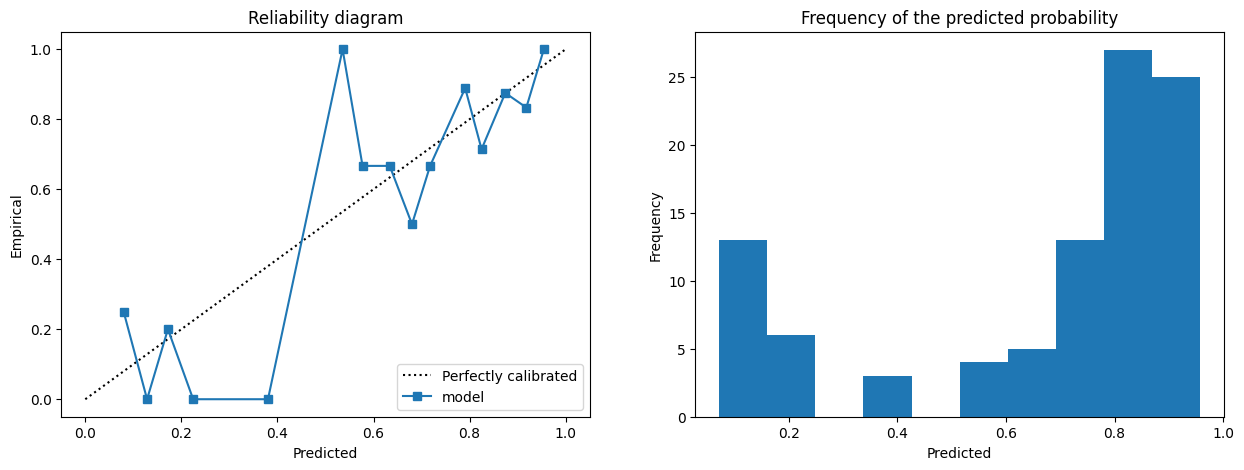

In [12]:
mse = plot_reliability_diagram(test["Loan_Status"], test["pred_prob"])
mse

The left figure is a **reliability diagram** which shows the relationship between the model’s predicted probability (x-axis), and the empirical probability (y-axis). The diagonal line represents the perfect calibration. Another figure is the histogram of predicted probability from the model. 

Miscalibration will be recognizable as a deviation from the diagonal line that represents the perfect calibration.

## Log loss

There is a metric called Log-loss or cross entropy which is used to measure the quality of the predicted probability.

$$
log\_loss = -\frac{1}{N}(\sum_{pos}\log(p_i) + \sum_{neg}\log(1 - p_i))
$$

It is difficult to interpret, generally use for comparison. Put it in simple way, the lower is better.

In [13]:
print("log-loss:", log_loss(test["Loan_Status"], test["pred_prob"]))

log-loss: 0.4777084512171119


From the result, the current model is not well calibrated as there are some points in the graph deviate from the diagonal line. However, perfect calibration is ideal, it is not always possible to achieve, but it may be acceptable depending on the use case. Anyway, we will show that we can improve this using probability calibration technique.

## Introduction to Probability calibration

Most probability calibration techniques don’t require any modification for the model. In other word, the calibration can be done out of the box, we can apply this technique to Neural Network, Random Forest, XGBoost, or whatever models in the shelf, as long as we can access to the probability. In order to perform the probability calibration, here are the steps to do:

* Train the calibrator using calibration dataset.
* When making the prediction (calibrated probability), we need to pass the input through the model to get predicted probability, and then pass it through the calibrator to get the calibrated probability.

![](../images/probability_calibration_flow.png)

In this notebook, we will focus on 2 popular techniques: Platt’s scaling, Isotonic regression.

### Platt's scaling

Platt’s scaling or Logistic regression is a technique to calibrate the probability to align with the true probability. It does this by training a Logistic regression as a calibrator, which can be mathematically represented by the following equation:

$$
P(Y|s_i) = \frac{1}{1 + e^{-(w_1 * s_i + w_2)}}
$$

Where, $s_i$ is the score output for $i^{th}$ sample, $w_1$, $w_2$ are the weights of the logistic regression. 

By minimizing the following loss function (mean square error):
$$
\mathbb{E}[(\bar{P} - P(Y|s_i))^2]
$$

Where $\bar{p}$ is the actual probability distribution.

### Isotonic regression

Unlike Platt’s scaling, Isotonic regression is a non-parametric model which doesn’t rely on any assumptions about empirical distribution of the probability. This allows it to calibrate the probability more accurate. However, one of the drawbacks is it can be overfitted easily.

![](../images/isotonic_regression.png)

## Let's start calibrating the model

Scikit-learn provides the module to do this for us, `CalibratedClassiferCV`. Where set the argument `method=’sigmoid’` will perform Platt’s scaling, and `method=’isotonic’` will perform Isotonic regression. We will use Isotonic regression as a calibrator.

In [14]:
calibrated_model = CalibratedClassifierCV(model, method="isotonic", ensemble=False)
calibrated_model.fit(
    train_encoded.drop("Loan_Status", axis=1), 
    train_encoded["Loan_Status"]
)

CalibratedClassifierCV(ensemble=False,
                       estimator=<catboost.core.CatBoostClassifier object at 0x16aae93a0>,
                       method='isotonic')

0.031143283424327622

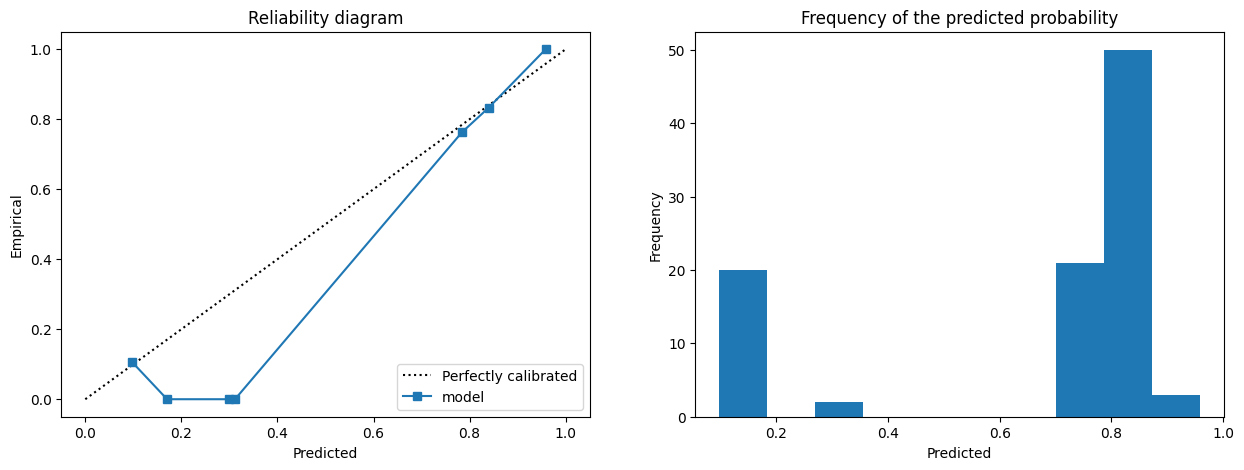

In [15]:
mse = plot_reliability_diagram(test["Loan_Status"], calibrated_model.predict_proba(test_encoded.drop("Loan_Status", axis=1))[:, 1])
mse

This reliability diagram looks better than the non-calibrated model.

In [16]:
test["pred_calibrated"] = calibrated_model.predict(test_encoded.drop("Loan_Status", axis=1))
test["pred_calibrated_prob"] = calibrated_model.predict_proba(test_encoded.drop("Loan_Status", axis=1))[:, 1]

In [17]:
print("Acc:", (test["Loan_Status"] == test["pred_calibrated"]).mean())

Acc: 0.8125


In [18]:
print("log-loss:", log_loss(test["Loan_Status"], test["pred_calibrated_prob"]))

log-loss: 0.4678476683633052


It shows that probability calibration helps to improve the model’s ability to predicted actual probability.

Let's see the average accuracy at all classification thresholds.

**Before calibration**

In [19]:
rs = []
for t in np.linspace(0, 1, 10):
    pred = test["pred_prob"] >= t
    r = (test["Loan_Status"] == pred).mean()
    rs.append(r)
    
np.mean(rs)

0.6854166666666666

**After calibration**

In [20]:
rs = []
for t in np.linspace(0, 1, 10):
    pred = test["pred_calibrated_prob"] >= t
    r = (test["Loan_Status"] == pred).mean()
    rs.append(r)
    
np.mean(rs)

0.696875

This shows that the probability calibration improves the model’s accuracy when using different classification thresholds.

## Conclusion

In summary, probability calibration techniques are used to adjust the predictions of the classifier to better align with the true probability. One thing to note that probability calibration is good when we want to consider using probability, otherwise it will not help you to improve the performance of the model.

# References

1. [Scikit-learn: Probability calibration](https://scikit-learn.org/stable/modules/calibration.html)
2. [An introduction to calibration (part II): Platt scaling, isotonic regression, and beta calibration](https://www.abzu.ai/tech-blog/calibration-introduction-part-2/)
3. [Why model calibration matters and how to achieve it](https://unofficialgoogledatascience.com/2021/04/why-model-calibration-matters-and-how.html)
4. [Isotonic Regression](https://en.wikipedia.org/wiki/Isotonic_regression)
5. [Are Model Predictions Probabilities?](https://pair.withgoogle.com/explorables/uncertainty-calibration/)
6. [Probability calibration workshop](https://youtu.be/A1NGGV3Z4m4)